### Section 1: Initial settings 

#### 1.1 Importing packages

In [2]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np
from numpy import cos, sin, arcsin, arccos, arctan

from sympy import init_printing
init_printing

%matplotlib inline

# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

#### 1.2 Conversion and time 

In [3]:
rad_mas = 206264806
rad_as  = 206264806/1000
as_mas  = 1000
AU_pc   = 4.84814e-6
as_rad = 4.84814e-6

timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num = m)

#### 1.3 Setting parameters

In [4]:
# star parameters 
m_star  = 1                                                   # mass of stat                        [M_solar]
vy_star = 4.74*(50*0.001)*(50)* (1/1.496e+8) * (3.154e+7)     # velocity of star in y direction     [AU/year]
vz_star = 1.7*vy_star                                         # velocity of star in z direction     [AU/year]
z_star  = 50*206265                                           # initial z positon of star           [AU]

# planet parameters 
inc           = 0                                             # orbital inclination                 [rad]
m_planet      = 0.0143188                                     # mass of planet                      [M_solar]
a_AU          = 0.6                                           # semi-major axis                     [AU]
e             = 0.2                                           # ellipticity of the orbit            [unitless]
omega         = 0                                             # argument of perihelion              [rad] 
OMEGA         = 0                                             # longitude of the ascending node     [rad]
tau           = 0                                             # time of pericentre passage          [years]
t0            = 0                                             # wrt Julian date                     [years]
P             = a_AU**(3/2)                                   # period of the system                [years]
proper_motion = 0.05                                          # proper motion of the system         [as/year]

# earth parameters
a_earth = 1

## Section 2: Functions

#### 2.1 Function called $get\_simulation$ that creates simulation with and without planet from initial conditions

In [5]:
def get_simulation(m_star = m_star, vy_star = vy_star, vz_star=vz_star, z_star = z_star, m_planet=m_planet, inc=inc, a_AU=a_AU, e=e):
    # with planet 
    sim_wp = rebound.Simulation()                                                        # create a simulation named sim_wp 

    sim_wp.units = ["msun","AU","year"]                                                  # setting units of sim_wpm

    sim_wp.add(m = 1)                                                                    # add the Sun as the central object 

    sim_wp.add(m = 3.0027e-6, a = 1, e = 0)                                              # add Earth in a 1 AU circular orbit 
    
    sim_wp.add(x = 1.031e7, vy = vy_star, m = m_star, z = z_star, vz = vz_star)          # add a star 50 pc away with calculated velocity and set parameters

    sim_wp.add(m = m_planet, a = a_AU, e = e, primary = sim_wp.particles[2], inc = inc)  # add planet from figure 3.1 caption and have it orbit the star 
    
    # barycentre particles
    com_particle  = sim_wp.calculate_com(first = 2,last = 4)
    ssbc_particle = sim_wp.calculate_com(first = 0,last = 2)
    
    # without planet
    sim = rebound.Simulation()                                                           # create a simulation named sim 

    sim.units = ["msun","AU","year"]                                                     # setting units of sim 

    sim.add(m = 1)                                                                       # add the Sun as the central object 

    sim.add(m = 3.0027e-6, a = 1, e = 0)                                                 # add Earth in a 1 AU circular orbit 

    sim.add(com_particle)                                                                # add a particle equivaent to the star-planet barycentre
    
    return(sim_wp, sim)

#### 2.2 Function called $simple\_function$ takes in a position vector and returns  $d, \delta$ and $\alpha$ 

In [6]:
def simple_function(R):
    Rx, Ry, Rz = R
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    return(d, delta,alpha)

#### 2.3 function called $simulation\_function$ uses a simulation and returns $delta$ and $alpha$ for the two vectors $r\_star - r\_earth$ and $r\_star - r\_ssbc$, as well as the intial conditions ___ needed for $______\_function$

In [30]:
def sim_function(sim, times=times):
    # making arrays filled with zeros 
    r_ssbc, r_earth, r_star = np.zeros((m,3)), np.zeros((m,3)), np.zeros((m,3))
    v_ssbc, v_star,  = np.zeros((m,3)), np.zeros((m,3))
    R_SE, delta_SE, alpha_SE = np.zeros((m,3)), np.zeros(m), np.zeros(m)
    R_SC, delta_SC, alpha_SC = np.zeros((m,3)), np.zeros(m), np.zeros(m)
    
    for i,t in enumerate(times):
        # integrate simulations
        sim.integrate(t)
        sim_wp.integrate(t)
        
        # set particles 
        ssbc_particle   = sim.calculate_com(first = 0,last = 2)  # solar system barycentre 
        earth_particle  = sim.particles[1]                       # earth 
        star_particle   = sim.particles[2]                       # star 
        
        # positions of particles 
        r_ssbc[i] = np.array(ssbc_particle.xyz)
        r_earth[i] = np.array(earth_particle.xyz)
        r_star[i] = np.array(star_particle.xyz)
        
        # position vectors 
        R_SE[i] = r_star[i] - r_earth[i]  # star - earth 
        R_SC[i] = r_star[i] - r_ssbc[i]   # star - ssbc 
    
        # using simple_function to turn position vectros into delta and alpha
        _, delta_SE[i], alpha_SE[i] = simple_function(R_SE[i])  # star - earth 
        _, delta_SC[i], alpha_SC[i] = simple_function(R_SC[i])  # star - ssbc 
        
        # velocities 
        v_ssbc[i]   = np.array(ssbc_particle.vxyz)    # ssbc
        v_star[i]   = np.array(star_particle.vxyz)    # star  
        
        # initial conditions needed for other functions 
        V0 = v_star[0] - v_ssbc[0]
        R0 = r_star[0] - r_ssbc[0]
            
    return(delta_SE, alpha_SE, delta_SC, alpha_SC, R0, V0)

#### Function called $sim\_planet\_function$ that takes in the sim_wp simulation and follows the same steps as $simulation\_function$ but for the vector $r\_planet - r\_earth$ and returns its $\delta$ and $\alpha$

In [31]:
def sim_planet_function(sim, times=times):
    # making arrays filled with zeros 
    r_earth, r_planet = np.zeros((m,3)), np.zeros((m,3))
    R_PE, delta_PE, alpha_PE = np.zeros((m,3)), np.zeros(m), np.zeros(m)
    
    for i,t in enumerate(times):
        # integrate simulation with planet
        sim_wp.integrate(t)
        
        # set particles 
        earth_particle  = sim.particles[1] 
        planet_particle = sim.particles[3]  
        
        # positions of particles 
        r_earth[i] = np.array(earth_particle.xyz)
        r_planet[i] = np.array(planet_particle.xyz)  
        
        # position vector
        R_PE[i] = r_planet[i] - r_earth[i] 
    
        # using simple_function to turn position vectro into delta and alpha
        _, delta_PE[i], alpha_PE[i] = simple_function(R_PE[i])  

    return(delta_PE, alpha_PE)

#### 2.4 Function called $equations\_function$ that takes in a position and velocity vector and returns proper motion and parallax terms of stellar motion

## Section 3: Using functions

#### 3.1 Simulation

In [9]:
# start simulations using get_simulation
sim_wp, sim = get_simulation()

# setting values for the without planet simulation
sim_values = sim_function(sim)
delta_SE_np, alpha_SE_np, delta_SC_np, alpha_SC_np, R0_np, V0_np = sim_values

# setting values for the with planet simulation using sim_function and sim_planet_function
sim_wp_values = sim_function(sim_wp)
delta_SE_wp, alpha_SE_wp, delta_SC_wp, alpha_SC_wp, R0_wp, V0_wp = sim_wp_values

sim_planet_values = sim_planet_function(sim_wp)
delta_PE, alpha_PE = sim_planet_values 

#### 3.2 Equations 

In [20]:
def equations_function(R, V, times=times, t0=t0, a_earth = a_earth, a_AU=a_AU, tau=tau, e=e, omega=omega, OMEGA=OMEGA, inc=inc):
    # finding d, delta, alpha and their derivatives using R and V (one value for each)
    d, delta, alpha = simple_function(R)
    Vx, Vy, Vz = V 
    
    sind, cosd, sina, cosa  = sin(delta), cos(delta), sin(alpha), cos(alpha)
    
    d_dot     =   Vx * cosa * cosd      +  Vy * sina * cosd     +  Vz * sind
    delta_dot = -(Vx * sind * cosa)/d   - (Vy * sina * sind)/d  + (Vz * cosd)/d
    alpha_dot = -(Vx * sina)/(d * cosd) + (Vy * cosa)/(d*cosd)
    
    T = times - t0    

    # proper motion term
    pm_term_dec = delta_dot*T
    pm_term_ra  = alpha_dot*T
    
    # parallax term 
    prlx_term_dec = (a_earth/d)*sin(delta)*cos(2*np.pi*T-alpha)
    prlx_term_ra  = (a_earth/(d*cos(delta)))*(sin(alpha)*cos(2*np.pi*T)-cos(alpha)*sin(2*np.pi*T))
    
    # planetary term
    parallax = 1/(d*AU_pc)                                                # parallax of the star         [as]
    P = a_AU**(3/2)                                                       # period of the planet         [years]
    a_as = ((parallax*m_planet)**3*(P/(m_star+m_planet))**2)**(1/3)       # angular semi-major axis      [as]
    
    # Thiele-Innes constants 
    A = a_as * (  cos(omega)  * cos(OMEGA) - sin(omega) * sin(OMEGA) * cos(inc))                       # [as]
    B = a_as * (  cos(omega)  * sin(OMEGA) + sin(omega) * cos(OMEGA) * cos(inc))                       # [as]
    F = a_as * ( - sin(omega) * cos(OMEGA) - cos(omega) * sin(OMEGA) * cos(inc))                       # [as]
    G = a_as * ( - sin(omega) * sin(OMEGA) + cos(omega) * cos(OMEGA) * cos(inc))                       # [as]
      
    M = ((2*np.pi)/((a_AU)**(3/2)))*(times - tau)    # [rad]
    f = M + 2*e*sin(M) + 5/4*e**2*sin(2*M) +e**3*((13/12)*sin(3*M)-1/4*sin(M))+e**4*(103/96*sin(4*M)-11/24*sin(2*M)) #[rad]
    r = (a_AU*(1-e**2))/(1+e*cos(f)) # [AU]
    
    # star planet barycentre - ssbc
    R_star_bc_x = d * (cosa*cosd - (a_earth/d)*cos(2*np.pi*T)) # [AU]
    R_star_bc_y = d * (sina*cosd - (a_earth/d)*sin(2*np.pi*T)) # [AU]
    R_star_bc_z = d * (sind)                                   # [AU]
    
    X = r * ( cos(OMEGA) * cos(f-omega) + sin(OMEGA) * sin(f-omega) * cos(inc) -(a_earth/d)*cos(2*np.pi*T)) # [AU]
    Y = r * (-sin(OMEGA) * cos(f-omega) + cos(OMEGA) * sin(f-omega) * cos(inc) -(a_earth/d)*sin(2*np.pi*T)) # [AU]
    Z = r * (sin(f-omega) * -sin(inc))# [AU]
    
    planetary_dec = B*X+G*Y # [AU*as]
    planetary_ra = A*X+F*Y # [AU*as]
    
    #R_planet = X, Y,Z
    #_, planet_signal_dec, planet_signal_ra = simple_function(R_planet)
    
    # combining all together 
    signal_dec = pm_term_dec + prlx_term_dec #+ planetary_dec
    signal_ra  = pm_term_ra  + prlx_term_ra  #+ planetary_ra
    
    return (pm_term_dec, pm_term_ra, prlx_term_dec, prlx_term_ra,signal_dec, signal_ra, planetary_dec, planetary_ra,)

In [21]:
equation_values = equations_function(R0_np, V0_np)
pm_term_dec, pm_term_ra, prlx_term_dec, prlx_term_ra,signal_dec, signal_ra, planetary_dec, planetary_ra = equation_values 

In [22]:
# plt.plot(planet_signal_ra*rad_mas, 
#          (planet_signal_dec-planet_signal_dec[0])*rad_mas)

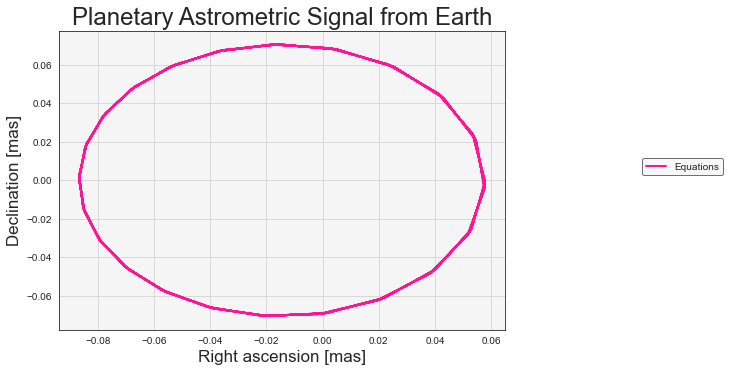

In [23]:
# plotting data 

# ra_diff = alpha_SE_np - alpha_SE_wp
# dec_diff = (delta_SE_np-delta_SE_np[0]) - (delta_SE_wp-delta_SE_wp[0])

# plt.plot(ra_diff*rad_mas, 
#          dec_diff*rad_mas, 
#          color='limegreen', 
#          lw=2,           
#          label = 'Simulation')


plt.plot(planetary_ra*as_mas, 
         (planetary_dec-planetary_dec[0])*as_mas, 
         color='deeppink', 
         lw=2,           
         label = 'Equations')

# set titles 
plt.title('Planetary Astrometric Signal from Earth', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

## Section 4: Plots

#### 4.1 Signal from simulation

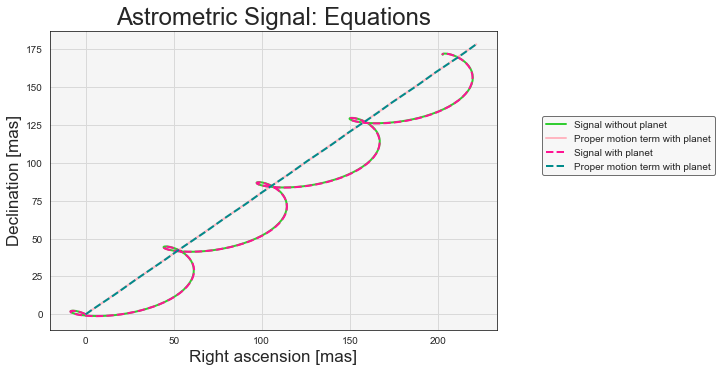

In [24]:
# plotting data 
plt.plot((alpha_SE_np)*rad_mas, 
         (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Signal without planet')

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='lightpink', 
         lw=2, 
         label = 'Proper motion term with planet')

plt.plot((alpha_SE_wp)*rad_mas, 
        (delta_SE_wp-delta_SE_wp[0])*rad_mas, 
         color='deeppink', 
         lw=2, 
         ls='--', 
         label = 'Signal with planet')

plt.plot((alpha_SC_wp-alpha_SC_wp[0])*rad_mas, 
         (delta_SC_wp-delta_SC_wp[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         ls='--', 
         label = 'Proper motion term with planet')

# set titles 
plt.title('Astrometric Signal: Equations', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.2 Planetary

##### 4.2.1 $r\_SE$

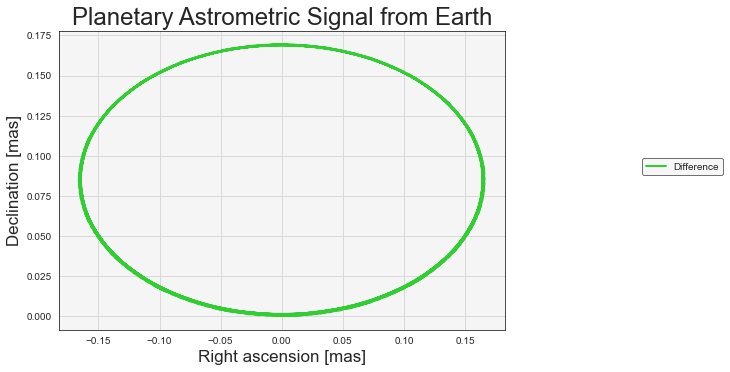

In [25]:
# plotting data 

ra_diff = alpha_SE_np - alpha_SE_wp

dec_diff = (delta_SE_np-delta_SE_np[0]) - (delta_SE_wp-delta_SE_wp[0])

plt.plot(ra_diff*rad_mas, 
         dec_diff*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Difference')

# plt.plot(planetary_ra*rad_mas, 
#          planetary_dec*rad_mas, 
#          color='deeppink', 
#          lw=2,           
#          label = 'Testing')


# set titles 
plt.title('Planetary Astrometric Signal from Earth', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

##### 4.2.2 $r\_SC$

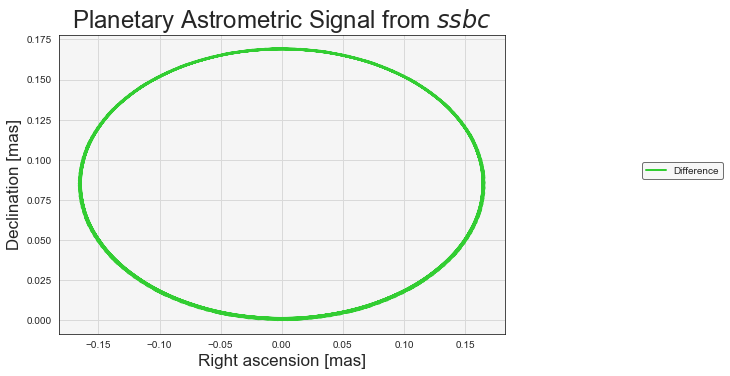

In [26]:
# plotting data 
ra_diff_SC = alpha_SC_np - alpha_SC_wp

dec_diff_SC = (delta_SC_np-delta_SC_np[0]) - (delta_SC_wp-delta_SC_wp[0])

plt.plot(ra_diff_SC*rad_mas, 
         dec_diff_SC*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Difference')

# set titles 
plt.title('Planetary Astrometric Signal from $ssbc$', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

##### 4.3.2 Planetary wiggles from with planet simulation

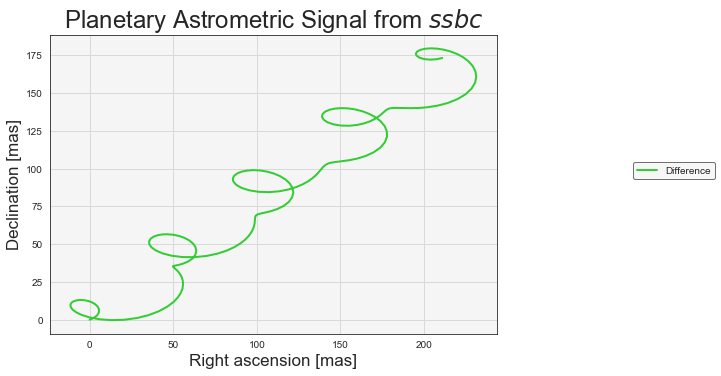

In [27]:
# plotting data 
plt.plot(alpha_PE*rad_mas, 
         (delta_PE-delta_PE[0])*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Difference')


# set titles 
plt.title('Planetary Astrometric Signal from $ssbc$', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.3 Equations plot

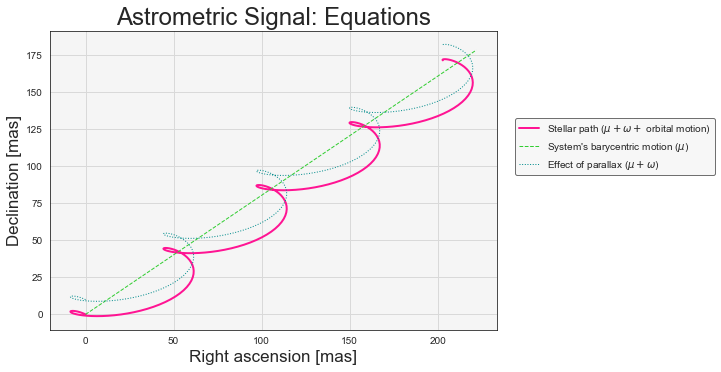

In [28]:
# plotting data 
plt.plot(signal_ra*rad_mas, 
         (signal_dec-signal_dec[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(pm_term_ra*rad_mas, 
         pm_term_dec*rad_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot(signal_ra*rad_mas, 
         signal_dec*rad_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax ($\mu + \omega $)')

# set titles 
plt.title('Astrometric Signal: Equations', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

####  4.4 Comparing simulation with planet and equation

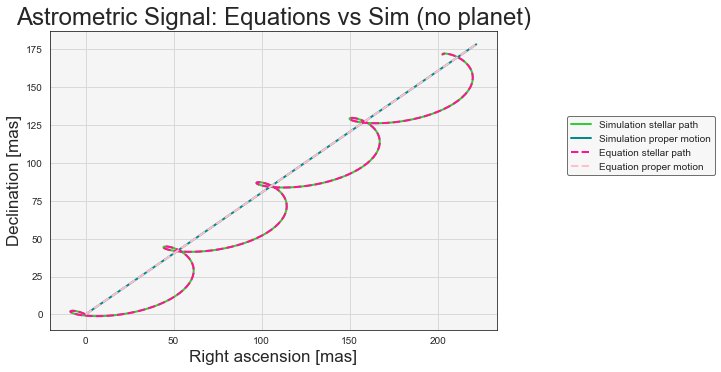

In [29]:
# plotting data 
plt.plot(alpha_SE_np*rad_mas, 
        (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2, 
         label = 'Simulation stellar path')

plt.plot(alpha_SC_np*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         label = 'Simulation proper motion')


plt.plot(signal_ra*rad_mas, 
         (signal_dec-signal_dec[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Equation stellar path')

plt.plot(pm_term_ra*rad_mas, 
         pm_term_dec*rad_mas, 
         color='pink', 
         lw=2,           
         ls='--', 
         label = 'Equation proper motion')

# set titles 
plt.title('Astrometric Signal: Equations vs Sim (no planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)